#  Sequence to Sequence Learning
:label:`sec_seq2seq`

As we have seen in :numref:`sec_machine_translation`,
in machine translation
both the input and output are a variable-length sequence.
To address this type of problem,
we have designed a general encoder-decoder architecture
in :numref:`sec_encoder-decoder`.
In this section,
we will
use two RNNs to design
the encoder and the decoder of
this architecture
and apply it to *sequence to sequence* learning
for machine translation
:cite:`Sutskever.Vinyals.Le.2014,Cho.Van-Merrienboer.Gulcehre.ea.2014`.

Following the design principle
of the encoder-decoder architecture,
the RNN encoder can
take a variable-length sequence as the input and transforms it into a fixed-shape hidden state.
In other words,
information of the input (source) sequence
is *encoded* in the hidden state of the RNN encoder.
To generate the output sequence token by token,
a separate RNN decoder
can predict the next token based on
what tokens have been seen (such as in language modeling) or generated,
together with the encoded information of the input sequence.
:numref:`fig_seq2seq` illustrates
how to use two RNNs
for sequence to sequence learning
in machine translation.


![Sequence to sequence learning with an RNN encoder and an RNN decoder.](../img/seq2seq.svg)
:label:`fig_seq2seq`

In :numref:`fig_seq2seq`,
the special "&lt;eos&gt;" token
marks the end of the sequence.
The model can stop making predictions
once this token is generated.
At the initial time step of the RNN decoder,
there are two special design decisions.
First, the special beginning-of-sequence "&lt;bos&gt;" token is an input.
Second,
the final hidden state of the RNN encoder is used
to initiate the hidden state of the decoder.
In designs such as :cite:`Sutskever.Vinyals.Le.2014`,
this is exactly
how the encoded input sequence information
is fed into the decoder for generating the output (target) sequence.
In some other designs such as :cite:`Cho.Van-Merrienboer.Gulcehre.ea.2014`,
the final hidden state of the encoder
is also fed into the decoder as
part of the inputs
at every time step as shown in :numref:`fig_seq2seq`.
Similar to the training of language models in
:numref:`sec_language_model`,
we can allow the labels to be the original output sequence,
shifted by one token:
"&lt;bos&gt;", "Ils", "regardent", "." $\rightarrow$
"Ils", "regardent", ".", "&lt;eos&gt;".


In the following,
we will explain the design of :numref:`fig_seq2seq`
in greater detail.
We will train this model for machine translation
on the English-French dataset as introduced in
:numref:`sec_machine_translation`.


In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

/home/mislav/anaconda3/envs/d2l/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


## Encoder

Technically speaking,
the encoder transforms an input sequence of variable length into a fixed-shape *context variable* $\mathbf{c}$, and encodes the input sequence information in this context variable.
As depicted in :numref:`fig_seq2seq`,
we can use an RNN to design the encoder.

Let us consider a sequence example (batch size: 1).
Suppose that
the input sequence is $x_1, \ldots, x_T$, such that $x_t$ is the $t^{\mathrm{th}}$ token in the input text sequence.
At time step $t$, the RNN transforms
the input feature vector $\mathbf{x}_t$ for $x_t$
and the hidden state $\mathbf{h} _{t-1}$ from the previous time step
into the current hidden state $\mathbf{h}_t$.
We can use a function $f$ to express the transformation of the RNN's recurrent layer:

$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}). $$

In general,
the encoder transforms the hidden states at
all the time steps
into the context variable through a customized function $q$:

$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T).$$

For example, when choosing $q(\mathbf{h}_1, \ldots, \mathbf{h}_T) = \mathbf{h}_T$ such as in :numref:`fig_seq2seq`,
the context variable is just the hidden state $\mathbf{h}_T$
of the input sequence at the final time step.

So far we have used a unidirectional RNN
to design the encoder,
where
a hidden state only depends on
the input subsequence at and before the time step of the hidden state.
We can also construct encoders using bidirectional RNNs. In this case, a hidden state depends on
the subsequence before and after the time step (including the input at the current time step), which encodes the information of the entire sequence.


Now let us implement the RNN encoder.
Note that we use an *embedding layer*
to obtain the feature vector for each token in the input sequence.
The weight
of an embedding layer
is a matrix
whose number of rows equals to the size of the input vocabulary (`vocab_size`)
and number of columns equals to the feature vector's dimension (`embed_size`).
For any input token index $i$,
the embedding layer
fetches the $i^{\mathrm{th}}$ row (starting from 0) of the weight matrix
to return its feature vector.
Besides,
here we choose a multilayer GRU to
implement the encoder.


In [37]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.permute(1, 0, 2)
        # When state is not mentioned, it defaults to zeros
        output, state = self.rnn(X)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

The returned variables of recurrent layers
have been explained in :numref:`sec_rnn-concise`.
Let us still use a concrete example
to illustrate the above encoder implementation.
Below
we instantiate a two-layer GRU encoder
whose number of hidden units is 16.
Given
a minibatch of sequence inputs `X`
(batch size: 4, number of time steps: 7),
the hidden states of the last layer
at all the time steps
(`output` return by the encoder's recurrent layers)
are a tensor
of shape
(number of time steps, batch size, number of hidden units).


In [38]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

Since a GRU is employed here,
the shape of the multilayer hidden states
at the final time step
is
(number of hidden layers, batch size, number of hidden units).
If an LSTM is used,
memory cell information will also be contained in `state`.


In [39]:
state.shape

torch.Size([2, 4, 16])

## Decoder
:label:`sec_seq2seq_decoder`

As we just mentioned,
the context variable $\mathbf{c}$ of the encoder's output encodes the entire input sequence $x_1, \ldots, x_T$. Given the output sequence $y_1, y_2, \ldots, y_{T'}$ from the training dataset,
for each time step $t'$
(the symbol differs from the time step $t$ of input sequences or encoders),
the probability of the decoder output $y_{t'}$
is conditional
on the previous output subsequence
$y_1, \ldots, y_{t'-1}$ and
the context variable $\mathbf{c}$, i.e., $P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$.

To model this conditional probability on sequences,
we can use another RNN as the decoder.
At any time step $t^\prime$ on the output sequence,
the RNN takes the output $y_{t^\prime-1}$ from the previous time step
and the context variable $\mathbf{c}$ as its input,
then transforms
them and
the previous hidden state $\mathbf{s}_{t^\prime-1}$
into the
hidden state $\mathbf{s}_{t^\prime}$ at the current time step.
As a result, we can use a function $g$ to express the transformation of the decoder's hidden layer:

$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}).$$
:eqlabel:`eq_seq2seq_s_t`

After obtaining the hidden state of the decoder,
we can use an output layer and the softmax operation to compute the conditional probability distribution
$P(y_{t^\prime} \mid y_1, \ldots, y_{t^\prime-1}, \mathbf{c})$ for the output at time step $t^\prime$.

Following :numref:`fig_seq2seq`,
when implementing the decoder as follows,
we directly use the hidden state at the final time step
of the encoder
to initialize the hidden state of the decoder.
This requires that the RNN encoder and the RNN decoder have the same number of layers and hidden units.
To further incorporate the encoded input sequence information,
the context variable is concatenated
with the decoder input at all the time steps.
To predict the probability distribution of the output token,
a fully-connected layer is used to transform
the hidden state at the final layer of the RNN decoder.


In [48]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

To illustrate the implemented decoder,
below we instantiate it with the same hyperparameters from the aforementioned encoder.
As we can see, the output shape of the decoder becomes (batch size, number of time steps, vocabulary size),
where the last dimension of the tensor stores the predicted token distribution.


In [49]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

To summarize,
the layers in the above RNN encoder-decoder model are illustrated in :numref:`fig_seq2seq_details`.

![Layers in an RNN encoder-decoder model.](../img/seq2seq-details.svg)
:label:`fig_seq2seq_details`

## Loss Function

At each time step, the decoder
predicts a probability distribution for the output tokens.
Similar to language modeling,
we can apply softmax to obtain the distribution
and calculate the cross-entropy loss for optimization.
Recall :numref:`sec_machine_translation`
that the special padding tokens
are appended to the end of sequences
so sequences of varying lengths
can be efficiently loaded
in minibatches of the same shape.
However,
prediction of padding tokens
should be excluded from loss calculations.

To this end,
we can use the following
`sequence_mask` function
to mask irrelevant entries with zero values
so later
multiplication of any irrelevant prediction
with zero equals to zero.
For example,
if the valid length of two sequences
excluding padding tokens
are one and two, respectively,
the remaining entries after
the first one
and the first two entries are cleared to zeros.


In [50]:
#@save
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    # added the below commented out lines to see how this works
    #print("maxlen:")
    #print(maxlen)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    #print("mask:")
    #print(mask)
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

We can also mask all the entries across the last
few axes.
If you like, you may even specify
to replace such entries with a non-zero value.


In [51]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

Now we can extend the softmax cross-entropy loss
to allow the masking of irrelevant predictions.
Initially,
masks for all the predicted tokens are set to one.
Once the valid length is given,
the mask corresponding to any padding token
will be cleared to zero.
In the end,
the loss for all the tokens
will be multipled by the mask to filter out
irrelevant predictions of padding tokens in the loss.


In [52]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""

    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss,
                                self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

For a sanity check, we can create three identical sequences.
Then we can
specify that the valid lengths of these sequences
are 4, 2, and 0, respectively.
As a result,
the loss of the first sequence
should be twice as large as that of the second sequence,
while the third sequence should have a zero loss.


In [53]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

## Training
:label:`sec_seq2seq_training`

In the following training loop,
we concatenate the special beginning-of-sequence token
and the original output sequence excluding the final token as
the input to the decoder, as shown in :numref:`fig_seq2seq`.
This is called *teacher forcing* because
the original output sequence (token labels) is fed into the decoder.
Alternatively,
we could also feed the *predicted* token
from the previous time step
as the current input to the decoder.


In [54]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

Now we can create and train an RNN encoder-decoder model
for sequence to sequence learning on the machine translation dataset.


loss 0.019, 10220.3 tokens/sec on cpu


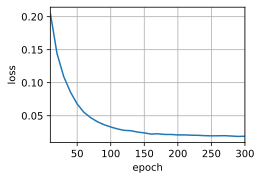

In [55]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## Prediction

To predict the output sequence
token by token,
at each decoder time step
the predicted token from the previous
time step is fed into the decoder as an input.
Similar to training,
at the initial time step
the beginning-of-sequence ("&lt;bos&gt;") token
is fed into the decoder.
This prediction process
is illustrated in :numref:`fig_seq2seq_predict`.
When the end-of-sequence ("&lt;eos&gt;") token is predicted,
the prediction of the output sequence is complete.


![Predicting the output sequence token by token using an RNN encoder-decoder.](../img/seq2seq-predict.svg)
:label:`fig_seq2seq_predict`

We will introduce different
strategies for sequence generation in
:numref:`sec_beam-search`.


In [56]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(
        torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),
        dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

## Evaluation of Predicted Sequences

We can evaluate a predicted sequence
by comparing it with the
label sequence (the ground-truth).
BLEU (Bilingual Evaluation Understudy),
though originally proposed for evaluating
machine translation results :cite:`Papineni.Roukos.Ward.ea.2002`,
has been extensively used in measuring
the quality of output sequences for different applications.
In principle, for any $n$-grams in the predicted sequence,
BLEU evaluates whether this $n$-grams appears
in the label sequence.

Denote by $p_n$
the precision of $n$-grams,
which is
the ratio of
the number of matched $n$-grams in
the predicted and label sequences
to
the number of $n$-grams in the predicted sequence.
To explain,
given a label sequence $A$, $B$, $C$, $D$, $E$, $F$,
and a predicted sequence $A$, $B$, $B$, $C$, $D$,
we have $p_1 = 4/5$,  $p_2 = 3/4$, $p_3 = 1/3$, and $p_4 = 0$.
Besides,
let $\mathrm{len}_{\text{label}}$ and $\mathrm{len}_{\text{pred}}$
be
the numbers of tokens in the label sequence and the predicted sequence, respectively.
Then, BLEU is defined as

$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$
:eqlabel:`eq_bleu`

where $k$ is the longest $n$-grams for matching.

Based on the definition of BLEU in :eqref:`eq_bleu`,
whenever the predicted sequence is the same as the label sequence, BLEU is 1.
Moreover,
since matching longer $n$-grams is more difficult,
BLEU assigns a greater weight
to a longer $n$-gram precision.
Specifically, when $p_n$ is fixed,
$p_n^{1/2^n}$ increases as $n$ grows (the original paper uses $p_n^{1/n}$).
Furthermore,
since
predicting shorter sequences
tends to obtain a higher $p_n$ value,
the coefficient before the multiplication term in :eqref:`eq_bleu`
penalizes shorter predicted sequences.
For example, when $k=2$,
given the label sequence $A$, $B$, $C$, $D$, $E$, $F$ and the predicted sequence $A$, $B$,
although $p_1 = p_2 = 1$, the penalty factor $\exp(1-6/2) \approx 0.14$ lowers the BLEU.

We implement the BLEU measure as follows.


In [57]:
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In the end,
we use the trained RNN encoder-decoder
to translate a few English sentences into French
and compute the BLEU of the results.


In [58]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu gagné gagné gagné gagné gagné emporté j’ai gagné, bleu 0.258
he's calm . => il est demande de aide-moi ., bleu 0.473
i'm home . => je suis chez moi <unk> ., bleu 0.803


## Summary

* Following the design of the encoder-decoder architecture, we can use two RNNs to design a model for sequence to sequence learning.
* When implementing the encoder and the decoder, we can use multilayer RNNs.
* We can use masks to filter out irrelevant computations, such as when calculating the loss.
* In encoder-decoder training, the teacher forcing approach feeds original output sequences (in contrast to predictions) into the decoder.
* BLEU is a popular measure for evaluating output sequences by matching $n$-grams between the predicted sequence and the label sequence.


## Exercises

1. Can you adjust the hyperparameters to improve the translation results?
1. Rerun the experiment without using masks in the loss calculation. What results do you observe? Why?
1. If the encoder and the decoder differ in the number of layers or the number of hidden units, how can we initialize the hidden state of the decoder?
1. In training, replace teacher forcing with feeding the prediction at the previous time step into the decoder. How does this influence the performance?
1. Rerun the experiment by replacing GRU with LSTM.
1. Are there any other ways to design the output layer of the decoder?


[Discussions](https://discuss.d2l.ai/t/1062)


## My exercise solutions

2. Rerun the experiment without using masks in the loss calculation. What results do you observe? Why?

In [37]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    #loss = MaskedSoftmaxCELoss()
    loss = nn.CrossEntropyLoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            #l = loss(Y_hat, Y, Y_valid_len)
            # 4 lines below are for debugging purposes
            #print("Y_hat.shape:")
            #print(Y_hat.shape)
            #print("Y.shape:")
            #print(Y.shape)
            l = loss(Y_hat.permute(0, 2, 1), Y)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.000, 16621.1 tokens/sec on cuda:0


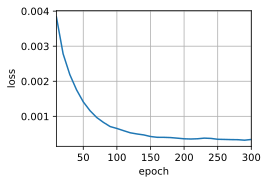

In [38]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

Well, I observe that the loss is smaller without the masks. I'll have to look into why.

## Test code related to exercise 2 below:

In [30]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            print("Y_hat.shape:")
            print(Y_hat.shape)
            print("Y.shape:")
            print(Y.shape)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

Now we can create and train an RNN encoder-decoder model
for sequence to sequence learning on the machine translation dataset.


Y_hat.shape:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
Y_hat.shape:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
Y_hat.shape:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
Y_hat.shape:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
Y_hat.shape:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
Y_hat.shape:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
Y_hat.shape:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
Y_hat.shape:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
Y_hat.shape:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
Y_hat.shape:
torch.Size([25, 10, 201])
Y.shape:
torch.Size([25, 10])
Y_hat.shape:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
Y_hat.shape:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
Y_hat.shape:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
Y_hat.shape:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
Y_hat.shape:
torch.Size([64, 10, 2

KeyboardInterrupt: 

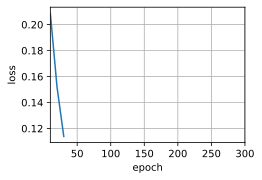

In [31]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

4. In training, replace teacher forcing with feeding the prediction at the previous time step into the decoder. How does this influence the performance?

In [73]:
import numpy as np

#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            print("Y.shape:")
            print(Y.shape)
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            print("bos.shape:")
            print(bos.shape)
            # if it's the first time this is running, we don't have Y_hat, and we need it:
            if not "Y_hat" in locals(): # https://stackoverflow.com/questions/843277/how-do-i-check-if-a-variable-exists
                print("Here")
                Y_hat = torch.rand(size=(Y.shape[0], Y.shape[1], len(tgt_vocab)), device=device)
            print("Y_hat.shape:")
            print(Y_hat.shape)
            Y_hat = np.argmax(Y_hat.cpu().detach().numpy(), axis=2)
            Y_hat = torch.tensor(Y_hat).to(device)
            dec_input = torch.cat([bos, Y_hat[:bos.shape[0], :-1]], 1)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            print("Y_hat.shape after net:")
            print(Y_hat.shape)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

len(src_vocab):
184
len(tgt_vocab):
201
Y.shape:
torch.Size([64, 10])
bos.shape:
torch.Size([64, 1])
Here
Y_hat.shape:
torch.Size([64, 10, 201])
Y_hat.shape after net:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
bos.shape:
torch.Size([64, 1])
Y_hat.shape:
torch.Size([64, 10, 201])
Y_hat.shape after net:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
bos.shape:
torch.Size([64, 1])
Y_hat.shape:
torch.Size([64, 10, 201])
Y_hat.shape after net:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
bos.shape:
torch.Size([64, 1])
Y_hat.shape:
torch.Size([64, 10, 201])
Y_hat.shape after net:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
bos.shape:
torch.Size([64, 1])
Y_hat.shape:
torch.Size([64, 10, 201])
Y_hat.shape after net:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
bos.shape:
torch.Size([64, 1])
Y_hat.shape:
torch.Size([64, 10, 201])
Y_hat.shape after net:
torch.Size([64, 10, 201])
Y.shape:
torch.Size([64, 10])
bos.shape:
torch.Size([64, 1])


RuntimeError: Sizes of tensors must match except in dimension 0. Got 25 and 64 (The offending index is 0)

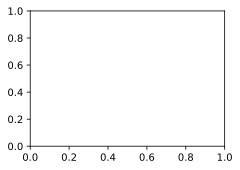

In [74]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
print("len(src_vocab):")
print(len(src_vocab))
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
print("len(tgt_vocab):")
print(len(tgt_vocab))
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## TODO: I have a bug here. It has to do with the shape of Y_hat. I have to look into this further. Maybe I should somehow compute Y_hat before passing the decoder initial state.

A new try:

In [55]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            print("dec_input.shape")
            print(dec_input.shape)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

dec_input.shape
torch.Size([64, 10])
X.shape
torch.Size([10, 64, 32])
dec_input.shape
torch.Size([64, 10])
X.shape
torch.Size([10, 64, 32])
dec_input.shape
torch.Size([64, 10])
X.shape
torch.Size([10, 64, 32])
dec_input.shape
torch.Size([64, 10])
X.shape
torch.Size([10, 64, 32])
dec_input.shape
torch.Size([64, 10])
X.shape
torch.Size([10, 64, 32])
dec_input.shape
torch.Size([64, 10])
X.shape
torch.Size([10, 64, 32])
dec_input.shape
torch.Size([64, 10])
X.shape
torch.Size([10, 64, 32])
dec_input.shape
torch.Size([64, 10])
X.shape
torch.Size([10, 64, 32])
dec_input.shape
torch.Size([64, 10])
X.shape
torch.Size([10, 64, 32])
dec_input.shape
torch.Size([25, 10])
X.shape
torch.Size([10, 25, 32])
dec_input.shape
torch.Size([64, 10])
X.shape
torch.Size([10, 64, 32])
dec_input.shape
torch.Size([64, 10])
X.shape
torch.Size([10, 64, 32])
dec_input.shape
torch.Size([64, 10])
X.shape
torch.Size([10, 64, 32])
dec_input.shape
torch.Size([64, 10])
X.shape
torch.Size([10, 64, 32])
dec_input.shape
torc

KeyboardInterrupt: 

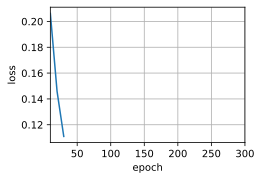

In [56]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

5. Rerun the experiment by replacing GRU with LSTM.

In [59]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, # not GRU, but LSTM
                          dropout=dropout)

    def forward(self, X, *args):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.permute(1, 0, 2)
        # When state is not mentioned, it defaults to zeros
        output, state = self.rnn(X)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [62]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=1)
encoder.eval()
X = torch.zeros((4, 1), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([1, 4, 16])

In [63]:
state[0].shape

torch.Size([1, 4, 16])

In [64]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size + num_hiddens, num_hiddens, num_layers, # not GRU, but LSTM
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        # Broadcast `context` so it has the same `num_steps` as `X` # I'm not using this here
        #context = state[-1].repeat(X.shape[0], 1, 1)
        context = state[-1]
        # Debug output below:
        #print("X.shape:")
        #print(X.shape)
        #print("context.shape:")
        #print(context.shape)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [65]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=1)
decoder.eval()
state = decoder.init_state(encoder(X))
print("state[0].shape")
print(state[0].shape)
output, state = decoder(X, state)
output.shape, state[0].shape

state[0].shape
torch.Size([1, 4, 16])


(torch.Size([4, 1, 10]), torch.Size([1, 4, 16]))

In [66]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
        if type(m) == nn.LSTM: # added for LSTM
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.227, 3458.1 tokens/sec on cpu


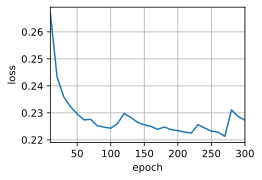

In [68]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 10, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

The loss is relatively large here... I have to look into what is going on here.

## TODO: Look into what is going on above and also see why is there a dimension mismatch in the below code

In [69]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(
        torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),
        dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [70]:
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [73]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

RuntimeError: torch.cat(): Sizes of tensors must match except in dimension 2. Got 1 and 10 in dimension 0 (The offending index is 1)